###    Задача:порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?

##### Описание данных:

* Таблица visits (лог сервера с информацией о посещениях сайта):
<br> Uid — уникальный идентификатор пользователя
<br> Device — категория устройства пользователя
<br> Start Ts — дата и время начала сессии
<br> End Ts — дата и время окончания сессии
<br> Source Id — идентификатор рекламного источника, из которого пришел пользователь
* Таблица orders (информация о заказах):
<br> Uid — уникальный id пользователя, который сделал заказ
<br> Buy Ts — дата и время заказа
<br> Revenue — выручка с этого заказа
* Таблица costs (информация о затратах на маркетинг):
<br> source_id — идентификатор рекламного источника
<br> dt — дата
<br> costs — затраты на этот рекламный источник в этот день

In [140]:
# загрузим библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Шаг 1. Загрузите данные и подготовьте их к анализу

In [141]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [142]:
visits.sample(5)

,Device,End Ts,Source Id,Start Ts,Uid
115489,touch,2017-12-09 09:40:00,5,2017-12-09 09:30:00,16007249273811860086
95652,desktop,2018-02-27 16:51:00,2,2018-02-27 16:10:00,16937732603709238104
247076,desktop,2018-03-28 09:20:00,1,2018-03-28 09:18:00,12604358519697355649
325539,desktop,2018-02-15 15:35:00,3,2018-02-15 15:35:00,7176041631027263855
297856,touch,2017-07-12 15:01:00,3,2017-07-12 14:59:00,17335270978702252442


In [143]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [144]:
orders.sample(5)

,Buy Ts,Revenue,Uid
12956,2017-10-15 22:21:00,3.54,11065612698064741649
43835,2018-04-11 23:23:00,36.67,2391345690817807103
48372,2018-05-21 23:33:00,0.73,10183918186170365119
13752,2017-10-20 15:41:00,3.05,2607894987576387783
42351,2018-03-27 13:08:00,2.95,9477482804671930473


In [145]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [146]:
costs.sample(5)

,source_id,dt,costs
1616,5,2017-11-12,145.53
689,2,2018-04-25,138.46
1760,5,2018-04-06,118.16
1299,4,2017-12-28,89.49
1900,9,2017-08-24,6.62


In [147]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


ВЫВОД: пропусков в даных,похоже, нет. Нужно будет преобразовать даты в формат datetime, а в таблицах visit и orders название колонок привести к нижнему регистру.

In [148]:
visits.columns = ['device','end_ts','source_id','start_ts','uid']
orders.columns = ['buy_ts','revenue','uid']
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

### Шаг 2. Постройте отчёты и посчитайте метрики
* Продукт
<br> Сколько людей пользуются в день, неделю, месяц?
<br> Сколько сессий в день?
<br> Сколько длится одна сессия?
<br> Как часто люди возвращаются?


In [149]:
visits['day'] = visits['start_ts'].dt.day
visits['week'] = visits['start_ts'].dt.week
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year
visits['date'] = visits['start_ts'].dt.date

In [150]:
#DAU
int(visits.groupby('date').agg({'uid':'nunique'}).mean())

907

In [151]:
#WAU
int(visits.groupby(['year','week']).agg({'uid':'nunique'}).mean())

5716

In [152]:
#MAU
int(visits.groupby(['year','month']).agg({'uid':'nunique'}).mean())

23228

<Figure size 864x1296 with 0 Axes>

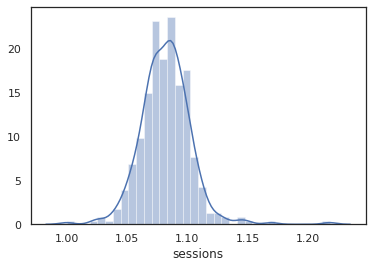

<Figure size 864x1296 with 0 Axes>

In [153]:
#сессий в день
SPD = visits.groupby('date').agg({'uid':['count','nunique']})
SPD.columns = ['n_sessions', 'n_users']
SPD['sessions'] = SPD['n_sessions'] / SPD['n_users'] 
sns.distplot(SPD['sessions'])
plt.figure(figsize = (12,18))

In [154]:
#ASL
visits['session_delta'] = (visits['end_ts']-visits['start_ts']).dt.seconds
visits['session_delta'].mean()

643.506488592098

<Figure size 864x1296 with 0 Axes>

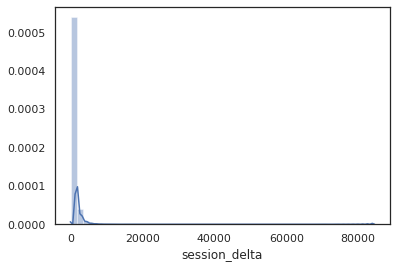

<Figure size 864x1296 with 0 Axes>

In [155]:
#посмотрим график
sns.distplot(visits['session_delta'])
plt.figure(figsize = (12,18))

#похоже очень много значений в районе 0

In [156]:
#ASL
# используем моду

visits['session_delta'].mode()

# выходит, самое распространенное время посещения сайта - 60 секунд

0    60
dtype: int64

In [157]:
#рассчитаем RetantionRate

#определим дату первой активности
first_activity = visits.groupby('uid')['date'].min()
first_activity.name = 'first_activity'
visits = visits.join(first_activity,on = 'uid')

In [158]:
# рассчитаем lifetime для когорт
visits['first_activity_month'] = visits['first_activity'].astype('datetime64[M]')
visits['activity_month'] = visits['date'].astype('datetime64[M]')
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime']/np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

In [159]:
#определим когорты
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users = initial_users.rename(columns = {'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users, on = 'first_activity_month')

In [160]:
#получим RetentionRate:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 
retention_pivot = cohorts.pivot_table(index ='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum' )
#уберём 0 месяц для информативности heatmap
retention_pivot = retention_pivot.drop(columns =0)

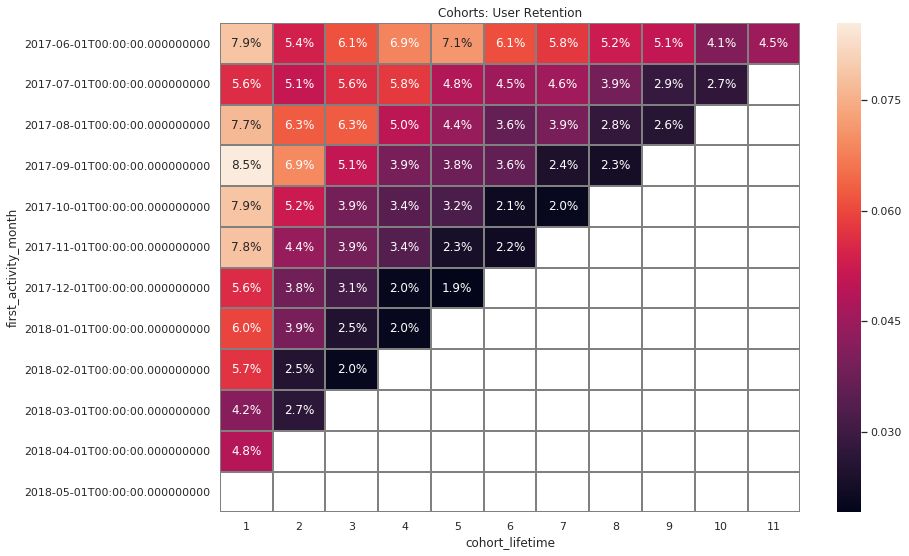

In [161]:
#построим тепловую карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Судя по heatmap, какая-то беда произошла в марте и апреле 2018, что возврат пользователей существенно ухудшился.


* Продажи
<br> Когда люди начинают покупать?
<br> Сколько раз покупают за период?
<br> Какой средний чек?
<br> Сколько денег приносят? (LTV)

In [162]:
# для ответа на вопрос, когда люди начинают покупать нам понадобится информация о первом визите и о первой покупке.
# информация о визитах есть в visits о покупках в orders. соединим эту информацию

first_visit = visits.groupby(['uid']).agg({'start_ts':'min'}).reset_index()
first_order = orders.groupby(['uid']).agg({'buy_ts':'min'}).reset_index()

buy_time = first_order.merge(first_visit, on='uid',how='left')
buy_time['buy_time'] = buy_time['buy_ts'] - buy_time['start_ts']
first_buy_time = (buy_time.groupby('uid')['buy_time'].min())/np.timedelta64(1,'m')


<Figure size 864x1296 with 0 Axes>

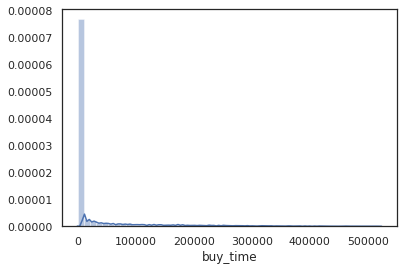

<Figure size 864x1296 with 0 Axes>

In [163]:
#посмотрим на графике
sns.distplot(first_buy_time)
plt.figure(figsize = (12,18))

#опять очень большое кол-во покупок в первые минуты

In [164]:
print('Медиана:',first_buy_time.median())
print('Мода:',int(first_buy_time.mode()))

#чаще всего покупка совершается за минуту, при этом медианное время - 16 минут

Медиана: 16.0
Мода: 1


In [165]:
#посмотрим, как много покупок совершили покупающие пользователи за период
buy_amount = orders.groupby('uid')['buy_ts'].count()
print('Самый активный покупатель',buy_amount.max())
print('Медианное число покупок:',buy_amount.median())

Самый активный покупатель 239
Медианное число покупок: 1.0


In [166]:
print('Среднией чек:',orders['revenue'].mean().astype('int'),'$')

Среднией чек: 4 $


In [167]:
#Рассчитаем LTV
first_order = buy_time.groupby('uid').agg({'buy_ts':'min'}).reset_index()
first_order.columns = ['uid', 'first_order_month']
first_order['first_order_month'] = first_order['first_order_month'].astype('datetime64[M]')

In [168]:
# определим размер когорты
cohort_sizes = first_order.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [169]:
# сгруппируем заказы по месяцам
new_order = orders.merge(first_order,on='uid')
new_order['order_month'] = new_order['buy_ts'].astype('datetime64[M]')
order_cohorts = new_order.groupby(['first_order_month','order_month']).agg({'revenue':'sum'}).reset_index()
order_cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [170]:
# проведём рассчёт срока жизни клиента и LTV
report = pd.merge(order_cohorts,cohort_sizes, on = 'first_order_month')
report['age'] = ((report['order_month'] - report['first_order_month'])/ np.timedelta64(1, 'M')).round().astype('int')
report['ltv'] = report['revenue']/report['n_buyers']
report.head()

,first_order_month,order_month,revenue,n_buyers,age,ltv
0,2017-06-01,2017-06-01,9557.49,2023,0,4.724414
1,2017-06-01,2017-07-01,981.82,2023,1,0.485329
2,2017-06-01,2017-08-01,885.34,2023,2,0.437637
3,2017-06-01,2017-09-01,1931.30,2023,3,0.954671
4,2017-06-01,2017-10-01,2068.58,2023,4,1.022531


In [171]:
# выведем результат
new_report = report.pivot_table(index = 'first_order_month', columns = 'age', values = 'ltv',aggfunc = 'mean').round()
new_report

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,5.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2017-07-01,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2017-08-01,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2017-09-01,6.0,1.0,1.0,4.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN
2017-10-01,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2017-11-01,5.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,5.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [172]:
# посмотрим на накопленный LTV:
new_report.cumsum(axis=1).mean(axis=0)

age
0      4.846154
1      5.272727
2      5.500000
3      6.222222
4      6.625000
5      7.285714
6      7.666667
7      8.400000
8      9.250000
9      8.000000
10    10.000000
11    13.000000
dtype: float64

Вывод: средний LTV за год - 13$, при этом около 30-40% от первой покупки



* Маркетинг
<br> Сколько денег потратили? Всего / на каждый источник / по времени
<br> Сколько стоило привлечение одного покупателя из каждого источника?
<br> На сколько окупились расходы? (ROI)
<br> Отобразите на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?

In [173]:
print('Всего потратили денег:',costs['costs'].sum())

Всего потратили денег: 329131.62


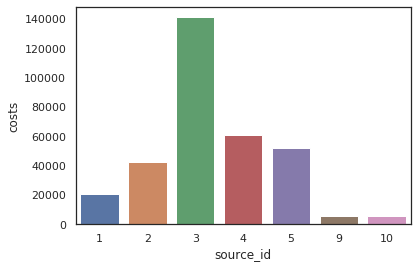

In [174]:
#сколько потратили на каждый источник
source_costs = costs.groupby('source_id').agg({'costs':'sum'}).reset_index()
sns.barplot(data =source_costs, x='source_id',y='costs')

Самый дорогостоящий источник №3, существенно выделяется среди остальных

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

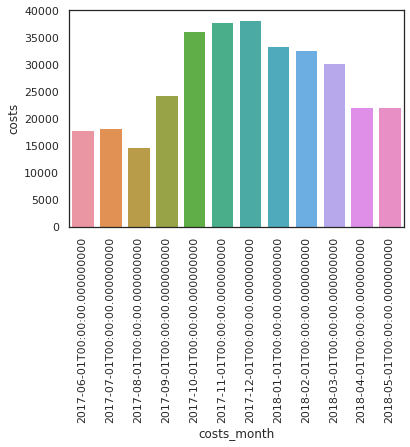

In [175]:
#сколько тратили по месяцам
costs['costs_month'] = costs['dt'].astype('datetime64[M]')
month_costs = costs.groupby('costs_month').agg({'costs':'sum'}).reset_index()
sns.barplot(data =month_costs, x='costs_month',y='costs')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

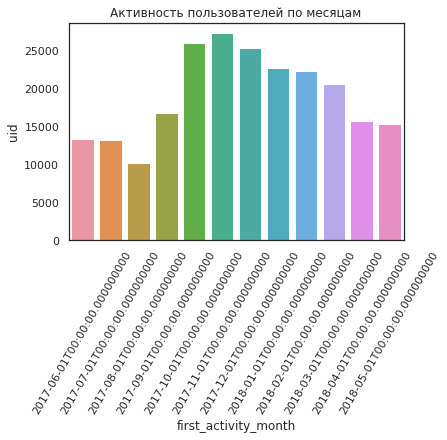

In [176]:
# сколько првлекали по месяцам
mont_user_activity = visits.groupby('first_activity_month').agg({'uid':'nunique'}).reset_index()
sns.barplot(data =mont_user_activity, x='first_activity_month',y='uid').set_title('Активность пользователей по месяцам')
plt.xticks(rotation=60)

In [177]:
#Сколько стоило привлечение одного покупателя из каждого источника?
user_source = visits.groupby('source_id').agg({'uid':'nunique'}).reset_index()
user_source.columns = ['source_id','n_users']
user_source_cost = user_source.merge(source_costs, on = 'source_id',how='left')
user_source_cost['cost_per_user'] = user_source_cost['costs'] / user_source_cost['n_users']
user_source_cost = user_source_cost.fillna(0)

Text(0.5, 1.0, 'Цена привлечения 1 пользователя')

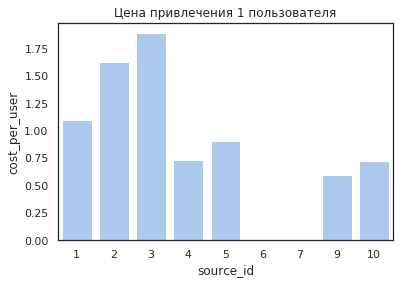

In [178]:
sns.set_color_codes("pastel")
sns.barplot(data =user_source_cost, x='source_id',y='cost_per_user',color = 'b' ).set_title("Цена привлечения 1 пользователя")

Text(0.5, 1.0, 'Привлечено пользователей по источникам')

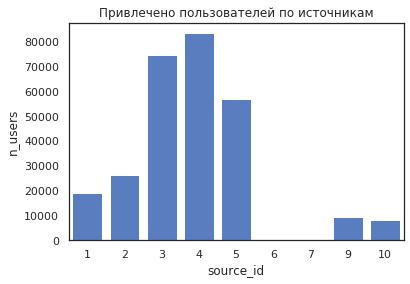

In [179]:
sns.set_color_codes("muted")
sns.barplot(data =user_source_cost, x='source_id',y='n_users', color='b').set_title("Привлечено пользователей по источникам")

Похоже что источники 4,5 стоят дешевле чем 1,2,3, но привлекают больше пользователей

In [180]:
# посчитаем ROI 
print('ROI:{:.2%}'.format((orders['revenue'].sum()-costs['costs'].sum())/costs['costs'].sum()))

ROI:-23.42%


In [181]:
#посчитаем ROMI
report = report.merge(month_costs, left_on='first_order_month', right_on='costs_month')
report['cac'] = report['costs']/report['n_buyers']
report

,first_order_month,order_month,revenue,n_buyers,age,ltv,costs_month,costs,cac
0,2017-06-01,2017-06-01,9557.49,2023,0,4.724414,2017-06-01,18015.00,8.905091
1,2017-06-01,2017-07-01,981.82,2023,1,0.485329,2017-06-01,18015.00,8.905091
2,2017-06-01,2017-08-01,885.34,2023,2,0.437637,2017-06-01,18015.00,8.905091
3,2017-06-01,2017-09-01,1931.30,2023,3,0.954671,2017-06-01,18015.00,8.905091
4,2017-06-01,2017-10-01,2068.58,2023,4,1.022531,2017-06-01,18015.00,8.905091
...,...,...,...,...,...,...,...,...,...
73,2018-03-01,2018-04-01,1063.05,3533,1,0.300892,2018-03-01,30415.27,8.608907
74,2018-03-01,2018-05-01,1114.87,3533,2,0.315559,2018-03-01,30415.27,8.608907
75,2018-04-01,2018-04-01,10600.69,2276,0,4.657597,2018-04-01,22289.38,9.793225
76,2018-04-01,2018-05-01,1209.92,2276,1,0.531599,2018-04-01,22289.38,9.793225


In [182]:
report['romi'] = report['ltv'] / report['cac']
output = report.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')

output.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,NaN,NaN,NaN
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,NaN,NaN,NaN,NaN
2017-11-01,0.55,0.60,0.62,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Июньская когорта окупилась на 6ой месяц, сентбрьская на 3.

In [183]:
#подготовим данные для графиков в зависимости от источника и устройства
costs['dt'] = costs['dt'].astype('datetime64').dt.date
user_activation = visits.groupby('uid').agg({'start_ts':'min','device':'first','source_id':'first'}).reset_index()
user_activation['dt'] = user_activation['start_ts'].dt.date
new_user_activation = (user_activation.reset_index().set_index(['source_id', 'dt']).join(costs.set_index(['source_id', 'dt']), how = 'left'))


In [184]:
user_price = new_user_activation.groupby(['source_id','dt']).agg({'uid':'count','costs':'max'})
user_price['cpu'] = user_price['costs']/user_price['uid']
user_price = user_price.drop(columns = ['uid','costs'])
new_user_activation = new_user_activation.join(user_price,how='left').reset_index()

In [185]:
new_user_activation = new_user_activation.drop(columns = 'index')
new_user_activation.head()

,source_id,dt,uid,start_ts,device,costs,costs_month,cpu
0,1,2017-06-01,585738041899923335,2017-06-01 19:15:00,desktop,75.2,2017-06-01,1.566667
1,1,2017-06-01,618675438905551322,2017-06-01 02:37:00,touch,75.2,2017-06-01,1.566667
2,1,2017-06-01,1074355127080856382,2017-06-01 09:21:00,desktop,75.2,2017-06-01,1.566667
3,1,2017-06-01,1186757012633220834,2017-06-01 10:48:00,desktop,75.2,2017-06-01,1.566667
4,1,2017-06-01,1292867924428534308,2017-06-01 12:53:00,desktop,75.2,2017-06-01,1.566667


Text(0.5, 1.0, 'Общие затраты на привлечение в разрезе устройств/источников')

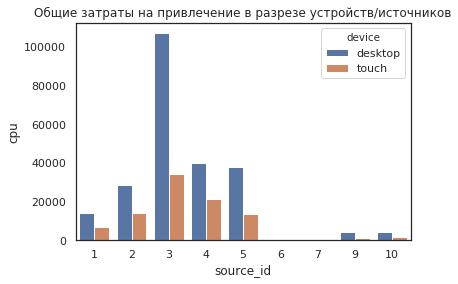

In [186]:
device_cost = new_user_activation.groupby(['source_id','device']).agg({'cpu':'sum'}).reset_index()
sns.barplot(data =device_cost, x='source_id',y='cpu',hue = 'device').set_title('Общие затраты на привлечение в разрезе устройств/источников')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

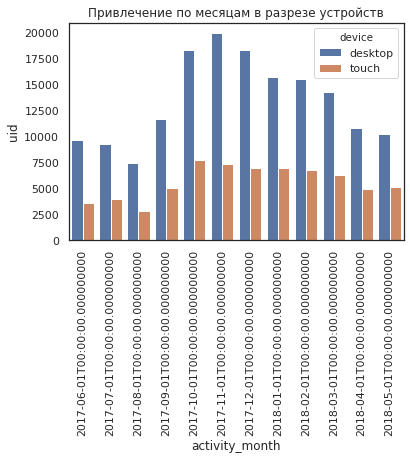

In [187]:
new_user_activation['activity_month'] = new_user_activation['start_ts'].astype('datetime64[M]')
month_device_user = new_user_activation.groupby(['device','activity_month']).agg({'uid':'nunique'}).reset_index()
sns.barplot(data =month_device_user, x='activity_month',y='uid',hue = 'device').set_title('Привлечение по месяцам в разрезе устройств')
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Привлечение по источникам в разрезе устройств')

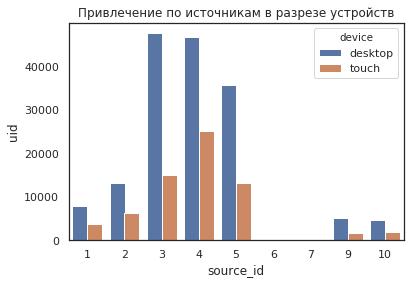

In [188]:
source_device_user = new_user_activation.groupby(['device','source_id']).agg({'uid':'nunique'}).reset_index()
sns.barplot(data =source_device_user, x='source_id',y='uid',hue = 'device').set_title('Привлечение по источникам в разрезе устройств')


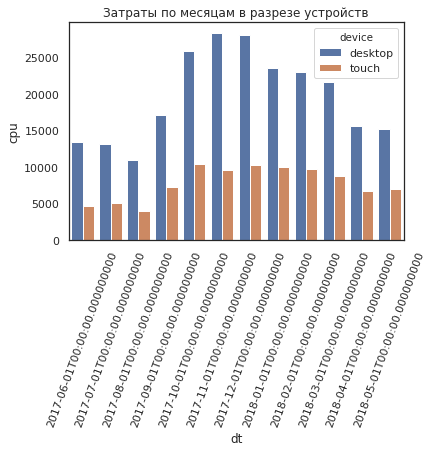

In [189]:
month_device_cost = new_user_activation
month_device_cost['dt'] = month_device_cost['dt'].astype('datetime64[M]')
month_device_cost = month_device_cost.groupby(['dt','device']).agg({'cpu':'sum'}).reset_index()

sns.barplot(data =month_device_cost, x='dt',y='cpu',hue = 'device').set_title('Затраты по месяцам в разрезе устройств')
plt.xticks(rotation=70)
plt.show()

Text(0.5, 1.0, 'Цена привлечения 1 пользователя в разрезе устройств/источников')

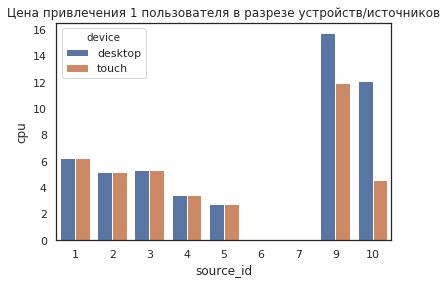

In [190]:
device_cpu = new_user_activation.groupby(['source_id','device']).agg({'cpu':'max'}).reset_index()
sns.barplot(data =device_cpu, x='source_id',y='cpu',hue = 'device').set_title('Цена привлечения 1 пользователя в разрезе устройств/источников')

In [191]:
new_user = pd.merge(orders,new_user_activation, on = ['uid'],how = 'left')

Text(0.5, 1.0, 'ROI в разрезе устройств/источников')

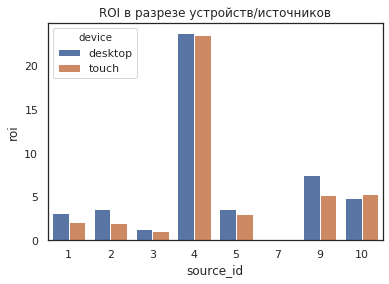

In [192]:
new_user['roi'] = (new_user['revenue']-new_user['cpu'])/new_user['cpu']
roi_user = new_user.groupby(['source_id','device']).agg({'roi':'mean'}).reset_index()
sns.barplot(data =roi_user, x='source_id',y='roi',hue = 'device').set_title('ROI в разрезе устройств/источников')

#### ВЫВОД:
    По итогам проведённого анализа, можно дать маркетологам следующие рекомендации:
    1. Самый дорогой источник привлечения №3, при этом больше пользователей пришло от источника 4, хотя расходы на него в 2 раза меньше - возможно есть смысл перераспределить часть бюджета из 3 на 4.
    2.Удержание (RR) ухудшилось в марте и апреле для всех когорт. Явных причин этому в рамках проекта найти не удалось - стоит проанализировать другие данные.
    3. Из анализируемых когорт, в период анализа окупились только две
    4. Затраты на desktop привлечение значительно выше мобильного, при этом для источников 9 и 10 цена привлечения одного клиента мобильного устройства ниже - возможно для этих источников следует перераспределить бюджет.
    5.Самый большой roi у привлеченных из источника 4 (почти одинаковый как для touch так и desktop), при этом цена привлечения 1 пользователя одна из самых низких - дополнительный фактор перераспределить бюджет на этот источник.
    6. Цена привлечения 1 пользователя по источнику 5 самая низкая, при этом roi выше чем у 1,2,3 следует перераспределить часть бюджетов 1,2,3 на этот источник. 
